# Legal Clause Similarity

Pipeline:
1) Load **all CSVs under ./data/**
2) Split **by unique clause** (70/15/15), **stratified by category** (no leakage)
3) Build **pairs per split**: same category = 1, cross category = 0
4) Tokenize + build vocab (no transformers)
5) Datasets/Dataloaders
6) Baselines: (A) Siamese BiLSTM, (B) BiLSTM + Additive Attention
7) Train, evaluate (Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC)
8) Curves (ROC/PR), confusion matrix, qualitative examples
9) Save artifacts + comparison table


In [29]:
import os, re, json, time, math, hashlib, random
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


Load CSV & Preview

In [30]:
DATA_DIR = Path("./data")

def load_one_csv(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[skip] {path.name}: {e}")
        return pd.DataFrame(columns=["clause_text","clause_type"])
    df.columns = [c.strip().lower() for c in df.columns]

    # pick a text column
    text_col = next((c for c in ["clause_text","text","clause","content","sentence","body"] if c in df.columns), None)
    if text_col is None:
        text_col = next((c for c in df.columns if df[c].dtype==object), None)
    if text_col is None:
        return pd.DataFrame(columns=["clause_text","clause_type"])

    # derive category
    if "clause_type" in df.columns:
        cat = df["clause_type"].astype(str)
    elif "category" in df.columns:
        cat = df["category"].astype(str)
    else:
        stem = re.sub(r"[_\-\s]+"," ", path.stem).strip().lower()
        cat = pd.Series([stem]*len(df), index=df.index)

    out = pd.DataFrame({
        "clause_text": df[text_col].astype(str),
        "clause_type": cat.astype(str)
    })
    out = out[out["clause_text"].str.len() > 3].dropna().drop_duplicates().reset_index(drop=True)
    return out

all_csvs = list(DATA_DIR.rglob("*.csv"))
print("Found CSVs:", len(all_csvs))

frames = []
for p in all_csvs:
    df_i = load_one_csv(p)
    if not df_i.empty:
        frames.append(df_i)

full = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["clause_text","clause_type"])
full = full.dropna().drop_duplicates().reset_index(drop=True)

# keep only categories with enough examples
counts = full["clause_type"].value_counts()
valid_cats = counts[counts >= 10].index.tolist()
full = full[full["clause_type"].isin(valid_cats)].reset_index(drop=True)

print("Clauses:", len(full), "| Categories kept (>=10):", len(valid_cats))
full.head(3)


Found CSVs: 395
Clauses: 150865 | Categories kept (>=10): 395


,clause_text,clause_type
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events


Split by unique clause (avoid leakage

In [31]:
def clause_id(s: str) -> str:
    return hashlib.md5(s.encode("utf-8")).hexdigest()

full["cid"] = full["clause_text"].apply(clause_id)

# one row per unique clause id for splitting
uniq = (full.drop_duplicates(subset=["cid"])
             .loc[:, ["cid", "clause_type"]]
             .reset_index(drop=True))

X = uniq["cid"].to_numpy()
y = uniq["clause_type"].to_numpy()

# 70/30 stratified
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(sss1.split(X, y))
train_cids = set(uniq.iloc[train_idx]["cid"])
temp_uniq = uniq.iloc[temp_idx].reset_index(drop=True)

# 15/15 stratified from the 30%
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
val_idx, test_idx = next(sss2.split(temp_uniq["cid"].to_numpy(), temp_uniq["clause_type"].to_numpy()))
val_cids  = set(temp_uniq.iloc[val_idx]["cid"])
test_cids = set(temp_uniq.iloc[test_idx]["cid"])

def subset_by_cids(df: pd.DataFrame, cids: set) -> pd.DataFrame:
    return df[df["cid"].isin(cids)].reset_index(drop=True)

train_clauses = subset_by_cids(full, train_cids)
val_clauses   = subset_by_cids(full, val_cids)
test_clauses  = subset_by_cids(full, test_cids)

for name, d in [("train",train_clauses),("val",val_clauses),("test",test_clauses)]:
    print(f"{name:5s} clauses={len(d):7d} | cats={d['clause_type'].nunique():4d}")


train clauses= 105605 | cats= 395
val   clauses=  22630 | cats= 395
test  clauses=  22630 | cats= 395


Building strong-labeled pairs per split

In [ ]:
import numpy as np

def build_pairs(df: pd.DataFrame, total_pos=6000, total_neg=6000) -> pd.DataFrame:
    groups = {c: df.index[df["clause_type"]==c].tolist() for c in df["clause_type"].unique()}
    cats = list(groups.keys())
    # positives: pair within category (fast)
    per_cat = max(1, total_pos // max(1, len(cats)))
    pos = []
    for c in cats:
        idx = groups[c][:]  # copy
        random.shuffle(idx)
        k = min(per_cat, len(idx)//2)
        for i in range(k):
            pos.append((idx[2*i], idx[2*i+1]))
    pos = pos[:total_pos]

    # negatives: across categories
    neg = []
    while len(neg) < total_neg and len(cats) >= 2:
        ca, cb = np.random.choice(cats, 2, replace=False)
        neg.append((np.random.choice(groups[ca]), np.random.choice(groups[cb])))

    def to_df(pairs, label):
        a_idx = [a for a,b in pairs]; b_idx = [b for a,b in pairs]
        return pd.DataFrame({
            "text_a": df.loc[a_idx, "clause_text"].tolist(),
            "text_b": df.loc[b_idx, "clause_text"].tolist(),
            "category_a": df.loc[a_idx, "clause_type"].tolist(),
            "category_b": df.loc[b_idx, "clause_type"].tolist(),
            "label": label
        })

    out = pd.concat([to_df(pos,1), to_df(neg,0)], ignore_index=True)
    return out.sample(frac=1, random_state=SEED).reset_index(drop=True)

train_pairs = build_pairs(train_clauses, total_pos=6000, total_neg=6000)
val_pairs   = build_pairs(val_clauses,   total_pos=1500, total_neg=1500)
test_pairs  = build_pairs(test_clauses,  total_pos=1500, total_neg=1500)

for name, d in [("train",train_pairs), ("val",val_pairs), ("test",test_pairs)]:
    pos = int((d.label==1).sum()); neg = int((d.label==0).sum())
    print(f"{name:5s} {d.shape} | pos={pos} neg={neg}")

train_df, val_df, test_df = train_pairs, val_pairs, test_pairs


train (11915, 5) | pos=5915 neg=6000
val   (2683, 5) | pos=1183 neg=1500
test  (2683, 5) | pos=1183 neg=1500


Tokenizer & Vocabulary

In [33]:
import re
PAD_TOKEN, UNK_TOKEN = "<pad>", "<unk>"

def basic_tokenize(text: str) -> List[str]:
    text = text.lower()
    return re.findall(r"[a-z0-9]+(?:'[a-z0-9]+)?", text)

def build_vocab_from_pairs(df_pairs: pd.DataFrame, min_freq=2, max_size=40000) -> Dict[str,int]:
    from collections import Counter
    counter = Counter()
    for t in pd.concat([df_pairs["text_a"], df_pairs["text_b"]]).astype(str):
        counter.update(basic_tokenize(t))
    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for tok, freq in counter.most_common():
        if freq < min_freq: continue
        if len(vocab) >= max_size: break
        vocab[tok] = len(vocab)
    return vocab

def encode(text: str, vocab: Dict[str,int]) -> List[int]:
    return [vocab.get(tok, 1) for tok in basic_tokenize(text)]  # 1 is UNK

vocab = build_vocab_from_pairs(train_df, min_freq=2, max_size=40000)
print("Vocab size:", len(vocab))


Vocab size: 13077


Dataset & Collate

In [35]:
class PairDataset(Dataset):
    def __init__(self, df: pd.DataFrame, vocab: Dict[str,int], max_len: int = 384):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self): return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        a = torch.tensor(encode(str(row["text_a"]), self.vocab)[:self.max_len], dtype=torch.long)
        b = torch.tensor(encode(str(row["text_b"]), self.vocab)[:self.max_len], dtype=torch.long)
        y = torch.tensor(int(row["label"]), dtype=torch.float32)
        return a, b, y

def collate_fn(batch):
    a_seqs, b_seqs, labels = zip(*batch)
    a_padded = pad_sequence(a_seqs, batch_first=True, padding_value=0)
    b_padded = pad_sequence(b_seqs, batch_first=True, padding_value=0)
    la = torch.tensor([len(x) for x in a_seqs], dtype=torch.long)
    lb = torch.tensor([len(x) for x in b_seqs], dtype=torch.long)
    labels = torch.stack(labels)
    return a_padded, la, b_padded, lb, labels

MAX_LEN   = 384     # increase if VRAM allows (e.g., 512)
BATCH_SIZE= 64

train_ds = PairDataset(train_df, vocab, MAX_LEN)
val_ds   = PairDataset(val_df,   vocab, MAX_LEN)
test_ds  = PairDataset(test_df,  vocab, MAX_LEN)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

len(train_ds), len(val_ds), len(test_ds)


(11915, 2683, 2683)

Models (Additive Attention, Encoder, Siamese Head)

In [36]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size: int):
        super().__init__()
        self.W = nn.Linear(hidden_size, hidden_size, bias=True)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, H, mask=None):  # H: (B,T,H)
        score = torch.tanh(self.W(H))           # (B,T,H)
        score = self.v(score).squeeze(-1)       # (B,T)
        if mask is not None:
            score = score.masked_fill(~mask, -1e9)
        attn = torch.softmax(score, dim=-1)     # (B,T)
        ctx = torch.bmm(attn.unsqueeze(1), H).squeeze(1)  # (B,H)
        return ctx, attn

class SentenceEncoderBiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden=128, dropout=0.2, use_attention=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden, batch_first=True, bidirectional=True)
        self.use_attention = use_attention
        if use_attention:
            self.attn = AdditiveAttention(hidden*2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        mask = (x != 0)
        emb = self.emb(x)
        H, _ = self.lstm(emb)                   # (B,T,2H)
        if self.use_attention:
            sent_vec, _ = self.attn(H, mask=mask)
        else:
            H_masked = H.masked_fill(~mask.unsqueeze(-1), -1e9)
            sent_vec, _ = torch.max(H_masked, dim=1)   # max-pool
        return self.dropout(sent_vec)

class SimilarityHead(nn.Module):
    def __init__(self, in_dim, hidden=128, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, a, b):
        feats = torch.cat([torch.abs(a-b), a*b, a, b], dim=-1)
        h = F.relu(self.fc1(feats))
        h = self.dropout(h)
        out = torch.sigmoid(self.fc2(h)).squeeze(-1)
        return out

class SiameseModel(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden=128, dropout=0.2, use_attention=False):
        super().__init__()
        self.encoder = SentenceEncoderBiLSTM(vocab_size, emb_dim, hidden, dropout, use_attention)
        enc_out = hidden*2
        self.head = SimilarityHead(in_dim=enc_out*4, hidden=128, dropout=dropout)

    def forward(self, a, la, b, lb):
        va = self.encoder(a, la)
        vb = self.encoder(b, lb)
        return self.head(va, vb)


Training & Eval Utilities (incl. PR-AUC + timing)

In [37]:
def batch_to_device(batch):
    a, la, b, lb, y = batch
    return a.to(DEVICE), la.to(DEVICE), b.to(DEVICE), lb.to(DEVICE), y.to(DEVICE)

def compute_metrics(probs, labels, threshold=0.5):
    probs = np.asarray(probs); labels = np.asarray(labels)
    preds = (probs >= threshold).astype(int)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    try:
        roc = roc_auc_score(labels, probs)
    except ValueError:
        roc = float("nan")
    p, r, _ = precision_recall_curve(labels, probs)
    pr_auc = auc(r, p)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc, "pr_auc": pr_auc}

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    t0 = time.time()
    losses, probs_all, labels_all = [], [], []
    for batch in loader:
        a, la, b, lb, y = batch_to_device(batch)
        optimizer.zero_grad(set_to_none=True)
        yhat = model(a, la, b, lb)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        probs_all.extend(yhat.detach().cpu().numpy().tolist())
        labels_all.extend(y.detach().cpu().numpy().tolist())
    dur = time.time() - t0
    return np.mean(losses), np.array(probs_all), np.array(labels_all), dur

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    t0 = time.time()
    losses, probs_all, labels_all = [], [], []
    for batch in loader:
        a, la, b, lb, y = batch_to_device(batch)
        yhat = model(a, la, b, lb)
        loss = criterion(yhat, y)
        losses.append(loss.item())
        probs_all.extend(yhat.detach().cpu().numpy().tolist())
        labels_all.extend(y.detach().cpu().numpy().tolist())
    dur = time.time() - t0
    return np.mean(losses), np.array(probs_all), np.array(labels_all), dur

def plot_training(history, title=""):
    plt.figure(figsize=(6,4))
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f'{title} Loss'); plt.legend(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history['train_f1'], label='train_f1')
    plt.plot(history['val_f1'], label='val_f1')
    plt.xlabel('Epoch'); plt.ylabel('F1'); plt.title(f'{title} F1'); plt.legend(); plt.show()

def tune_threshold(y_true, y_prob):
    best_t, best_f1 = 0.5, -1
    for t in np.linspace(0.1, 0.9, 81):
        preds = (np.asarray(y_prob) >= t).astype(int)
        f1 = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)[2]
        if f1 > best_f1: best_f1, best_t = f1, t
    return best_t, best_f1


Train Baseline A (Siamese BiLSTM)

[A][Ep 01] train loss 0.3398 f1 0.808 | val loss 0.0145 f1 0.998 roc 0.998 prAUC 0.995 | t(train)=10.5s t(val)=1.1s | thr* 0.29 (F1=0.998)
[A][Ep 02] train loss 0.0117 f1 0.998 | val loss 0.0122 f1 0.998 roc 0.999 prAUC 0.998 | t(train)=10.2s t(val)=1.1s | thr* 0.12 (F1=0.998)
[A][Ep 03] train loss 0.0085 f1 0.999 | val loss 0.0105 f1 0.998 roc 1.000 prAUC 1.000 | t(train)=10.2s t(val)=1.1s | thr* 0.10 (F1=0.998)
[A][Ep 04] train loss 0.0073 f1 0.999 | val loss 0.0106 f1 0.998 roc 1.000 prAUC 1.000 | t(train)=10.3s t(val)=1.1s | thr* 0.10 (F1=0.998)
[A][Ep 05] train loss 0.0048 f1 0.999 | val loss 0.0114 f1 0.998 roc 1.000 prAUC 1.000 | t(train)=10.3s t(val)=1.1s | thr* 0.16 (F1=0.998)
[A][Ep 06] train loss 0.0056 f1 0.999 | val loss 0.0109 f1 0.998 roc 1.000 prAUC 1.000 | t(train)=10.3s t(val)=1.1s | thr* 0.42 (F1=0.998)


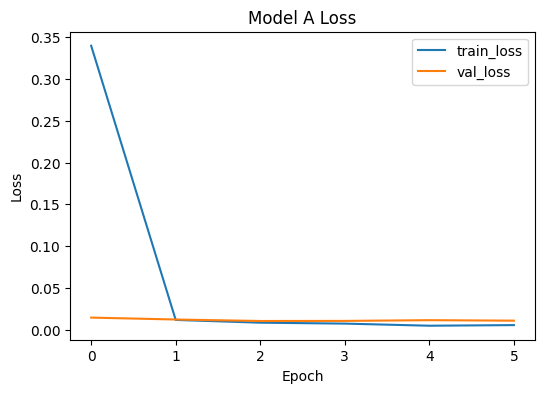

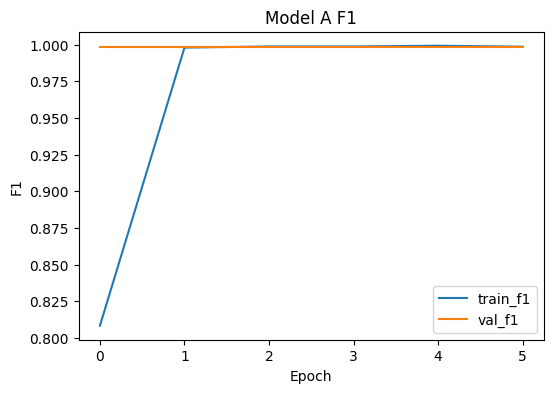

Test metrics (Model A @ tuned thr): {'accuracy': 0.9973909802459933, 'precision': 0.9941176470588236, 'recall': 1.0, 'f1': 0.9970501474926253, 'roc_auc': 0.9977805015497323, 'pr_auc': 0.9925960676106798}


In [38]:
EPOCHS = 6
LR = 2e-3
EMB_DIM = 128
HIDDEN = 128
DROPOUT = 0.2

model_a = SiameseModel(len(vocab), EMB_DIM, HIDDEN, DROPOUT, use_attention=False).to(DEVICE)
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=LR)
criterion = nn.BCELoss()

history_a = {"train_loss":[], "val_loss":[], "train_f1":[], "val_f1":[], "train_time":[], "val_time":[]}
best_val_f1, best_state = -1, None
va_best_threshold = 0.5

for ep in range(1, EPOCHS+1):
    tr_loss, tr_prob, tr_lbl, tr_time = train_epoch(model_a, train_dl, optimizer_a, criterion)
    va_loss, va_prob, va_lbl, va_time = eval_epoch(model_a, val_dl, criterion)
    tr_m = compute_metrics(tr_prob, tr_lbl)
    va_m = compute_metrics(va_prob, va_lbl)

    # tune decision threshold on validation for best F1
    thr, thr_f1 = tune_threshold(va_lbl, va_prob)
    va_best_threshold = thr

    history_a["train_loss"].append(tr_loss); history_a["val_loss"].append(va_loss)
    history_a["train_f1"].append(tr_m["f1"]); history_a["val_f1"].append(va_m["f1"])
    history_a["train_time"].append(tr_time);  history_a["val_time"].append(va_time)

    print(f"[A][Ep {ep:02d}] train loss {tr_loss:.4f} f1 {tr_m['f1']:.3f} | "
          f"val loss {va_loss:.4f} f1 {va_m['f1']:.3f} roc {va_m['roc_auc']:.3f} prAUC {va_m['pr_auc']:.3f} | "
          f"t(train)={tr_time:.1f}s t(val)={va_time:.1f}s | thr* {thr:.2f} (F1={thr_f1:.3f})")

    if va_m["f1"] > best_val_f1:
        best_val_f1 = va_m["f1"]
        best_state = {k: v.detach().cpu() for k, v in model_a.state_dict().items()}

plot_training(history_a, "Model A")

# test with best weights
model_a.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
te_loss_a, te_prob_a, te_lbl_a, _ = eval_epoch(model_a, test_dl, criterion)
te_m_a = compute_metrics(te_prob_a, te_lbl_a, threshold=va_best_threshold)
print("Test metrics (Model A @ tuned thr):", te_m_a)


Train Baseline B (BiLSTM + Additive Attention)

[B][Ep 01] train loss 0.4290 f1 0.731 | val loss 0.0424 f1 0.989 roc 0.999 prAUC 0.995 | t(train)=11.8s t(val)=1.2s | thr* 0.89 (F1=0.997)
[B][Ep 02] train loss 0.0154 f1 0.997 | val loss 0.0142 f1 0.998 roc 0.999 prAUC 0.997 | t(train)=11.6s t(val)=1.2s | thr* 0.87 (F1=0.999)
[B][Ep 03] train loss 0.0069 f1 0.999 | val loss 0.0112 f1 0.999 roc 0.999 prAUC 0.998 | t(train)=11.4s t(val)=1.2s | thr* 0.26 (F1=0.999)
[B][Ep 04] train loss 0.0050 f1 0.999 | val loss 0.0118 f1 0.999 roc 0.999 prAUC 0.998 | t(train)=11.6s t(val)=1.2s | thr* 0.10 (F1=0.999)
[B][Ep 05] train loss 0.0034 f1 0.999 | val loss 0.0143 f1 0.999 roc 0.999 prAUC 0.998 | t(train)=11.6s t(val)=1.2s | thr* 0.25 (F1=0.999)
[B][Ep 06] train loss 0.0028 f1 0.999 | val loss 0.0134 f1 0.999 roc 0.999 prAUC 0.999 | t(train)=11.6s t(val)=1.2s | thr* 0.20 (F1=0.999)


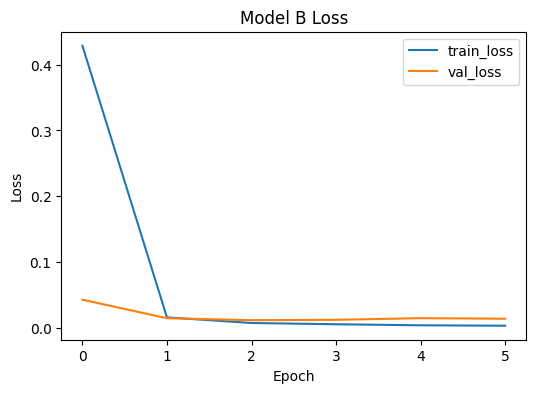

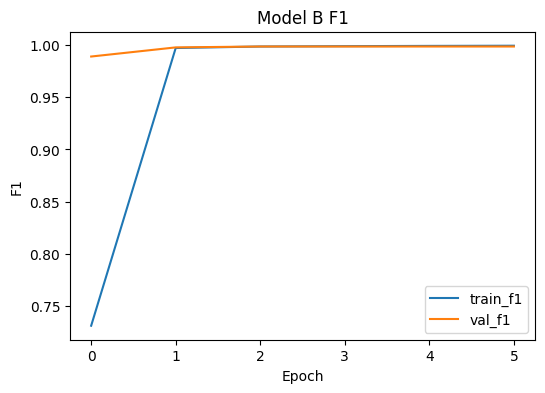

Test metrics (Model B @ tuned thr): {'accuracy': 0.9977636973537085, 'precision': 0.9949537426408747, 'recall': 1.0, 'f1': 0.9974704890387859, 'roc_auc': 0.9977326007326007, 'pr_auc': 0.9941541756071322}


In [39]:
model_b = SiameseModel(len(vocab), EMB_DIM, HIDDEN, DROPOUT, use_attention=True).to(DEVICE)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=LR)

history_b = {"train_loss":[], "val_loss":[], "train_f1":[], "val_f1":[], "train_time":[], "val_time":[]}
best_val_f1_b, best_state_b = -1, None
vb_best_threshold = 0.5

for ep in range(1, EPOCHS+1):
    tr_loss, tr_prob, tr_lbl, tr_time = train_epoch(model_b, train_dl, optimizer_b, criterion)
    va_loss, va_prob, va_lbl, va_time = eval_epoch(model_b, val_dl, criterion)
    tr_m = compute_metrics(tr_prob, tr_lbl)
    va_m = compute_metrics(va_prob, va_lbl)

    thr, thr_f1 = tune_threshold(va_lbl, va_prob)
    vb_best_threshold = thr

    history_b["train_loss"].append(tr_loss); history_b["val_loss"].append(va_loss)
    history_b["train_f1"].append(tr_m["f1"]); history_b["val_f1"].append(va_m["f1"])
    history_b["train_time"].append(tr_time);  history_b["val_time"].append(va_time)

    print(f"[B][Ep {ep:02d}] train loss {tr_loss:.4f} f1 {tr_m['f1']:.3f} | "
          f"val loss {va_loss:.4f} f1 {va_m['f1']:.3f} roc {va_m['roc_auc']:.3f} prAUC {va_m['pr_auc']:.3f} | "
          f"t(train)={tr_time:.1f}s t(val)={va_time:.1f}s | thr* {thr:.2f} (F1={thr_f1:.3f})")

plot_training(history_b, "Model B")

model_b.load_state_dict({k: v.to(DEVICE) for k, v in best_state_b.items()} if best_state_b else model_b.state_dict())
te_loss_b, te_prob_b, te_lbl_b, _ = eval_epoch(model_b, test_dl, criterion)
te_m_b = compute_metrics(te_prob_b, te_lbl_b, threshold=vb_best_threshold)
print("Test metrics (Model B @ tuned thr):", te_m_b)


Curves: ROC, PR & Confusion Matrix

Model A curves and confusion:


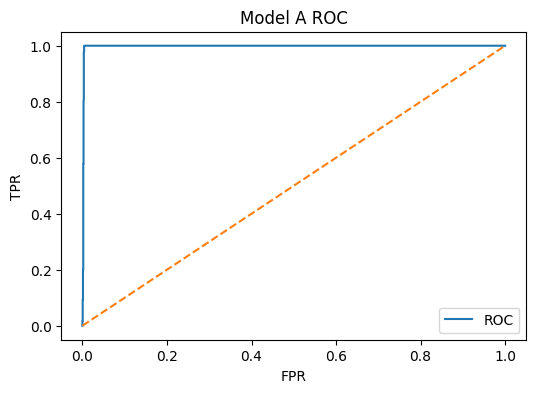

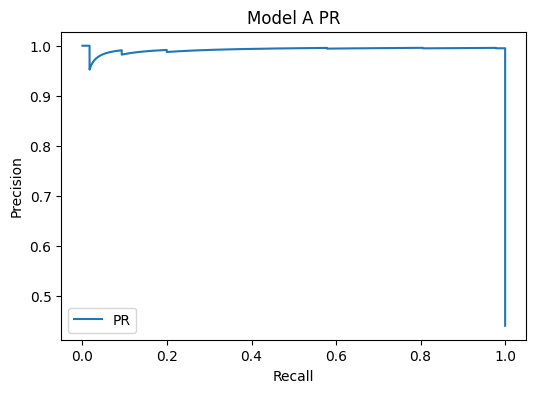

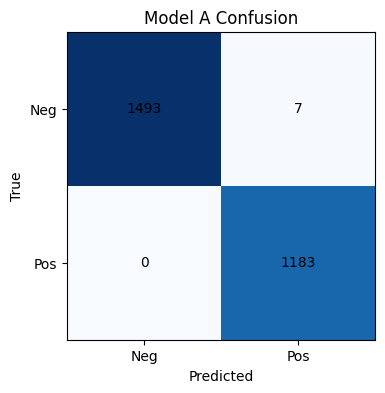

Model B curves and confusion:


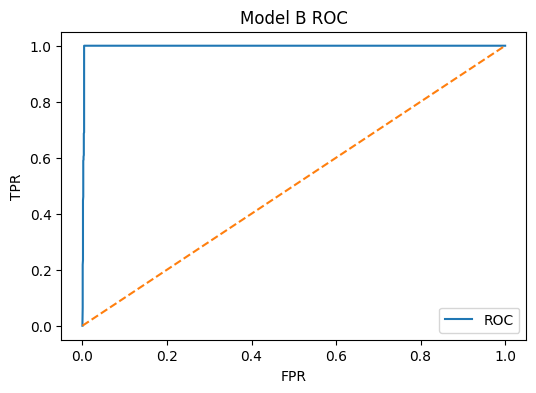

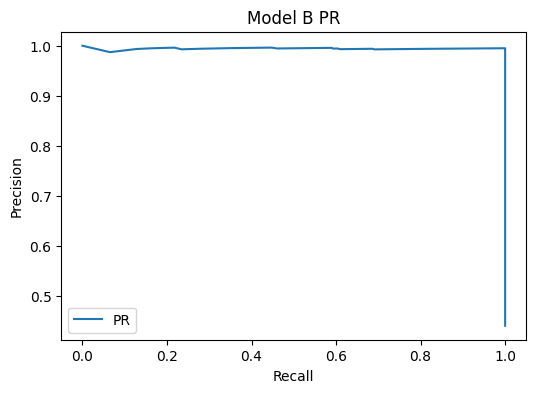

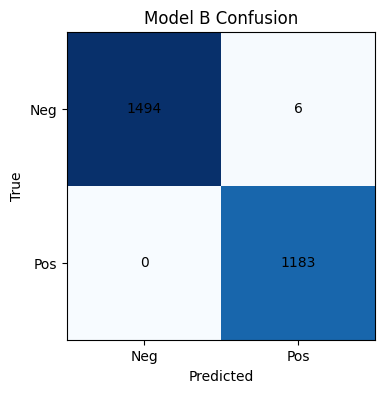

In [40]:
def plot_roc_pr(y_true, y_prob, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,4)); plt.plot(fpr, tpr, label='ROC'); plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'{title} ROC'); plt.legend(); plt.show()
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6,4)); plt.plot(rec, prec, label='PR')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'{title} PR'); plt.legend(); plt.show()

def plot_confusion(y_true, y_prob, threshold=0.5, title='Confusion Matrix'):
    y_pred = (np.asarray(y_prob) >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Neg','Pos']); ax.set_yticklabels(['Neg','Pos'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center')
    plt.show()

print("Model A curves and confusion:")
plot_roc_pr(te_lbl_a, te_prob_a, "Model A")
plot_confusion(te_lbl_a, te_prob_a, threshold=va_best_threshold, title="Model A Confusion")

print("Model B curves and confusion:")
plot_roc_pr(te_lbl_b, te_prob_b, "Model B")
plot_confusion(te_lbl_b, te_prob_b, threshold=vb_best_threshold, title="Model B Confusion")


Qualitative Examples (Correct vs Incorrect)

In [41]:
def sample_examples(df_split: pd.DataFrame, probs, top_k=3, threshold=0.5):
    probs = np.asarray(probs)
    preds = (probs >= threshold).astype(int)
    labels = df_split['label'].to_numpy()
    correct_mask = (preds == labels)
    wrong_mask   = ~correct_mask

    print("\n=== Correct ===")
    for i in np.where(correct_mask)[0][:top_k]:
        row = df_split.iloc[i]
        print(f"label={row['label']} prob={probs[i]:.2f}\nA: {row['text_a']}\nB: {row['text_b']}\n---")

    print("\n=== Incorrect ===")
    for i in np.where(wrong_mask)[0][:top_k]:
        row = df_split.iloc[i]
        print(f"label={row['label']} prob={probs[i]:.2f}\nA: {row['text_a']}\nB: {row['text_b']}\n---")

print("Model A examples:")
sample_examples(test_df.reset_index(drop=True), te_prob_a, top_k=3, threshold=va_best_threshold)

print("\nModel B examples:")
sample_examples(test_df.reset_index(drop=True), te_prob_b, top_k=3, threshold=vb_best_threshold)


Model A examples:

=== Correct ===
label=0 prob=0.00
A: Security. (a) Seller, at all times during the Term of this Agreement, shall either (i) maintain a Credit Rating at least equal to Investment Grade (the “Credit Requirements”) or (ii) provide Security in accordance with Section 6.3(b). Prior to the Confirmation Effective Date and at any time upon the request of Buyer, Seller (or its Credit Support Provider at any time that a guaranty delivered pursuant to Paragraph (A) of Subsection (b) of this Section is in effect) shall establish that it meets the Credit Requirements by providing (x) a certificate of an authorized officer, accompanied by supporting certified financial statements and (y) documentation of all Credit Ratings. Seller shall inform the Buyer within one (1) Business Day of any failure of it or its Credit Support Provider (at any time that a guaranty delivered pursuant to Paragraph (A) of Subsection (b) of this Section is in effect) to meet Credit Requirements, or of bei

Save Artifacts

In [ ]:
ART_DIR = "./artifacts_legal_similarity"
os.makedirs(ART_DIR, exist_ok=True)

# Save vocab and pairs
with open(os.path.join(ART_DIR, "vocab.json"), "w") as f:
    json.dump(vocab, f)

train_df.to_csv(os.path.join(ART_DIR, "train_pairs.csv"), index=False)
val_df.to_csv(os.path.join(ART_DIR, "val_pairs.csv"), index=False)
test_df.to_csv(os.path.join(ART_DIR, "test_pairs.csv"), index=False)

# Save model weights
torch.save(model_a.state_dict(), os.path.join(ART_DIR, "model_a_siamese_bilstm.pt"))
torch.save(model_b.state_dict(), os.path.join(ART_DIR, "model_b_bilstm_attention.pt"))

def row(name, m, train_hist):
    mean_epoch_time = float(np.mean(train_hist["train_time"])) + float(np.mean(train_hist["val_time"]))
    return {
        "Model": name,
        "Accuracy": round(m["accuracy"], 4),
        "Precision": round(m["precision"], 4),
        "Recall": round(m["recall"], 4),
        "F1": round(m["f1"], 4),
        "ROC-AUC": round(m["roc_auc"], 4) if not math.isnan(m["roc_auc"]) else None,
        "PR-AUC": round(m["pr_auc"], 4),
        "Avg Epoch Time (s)": round(mean_epoch_time, 3),
    }

table = pd.DataFrame([
    row("Siamese BiLSTM", te_m_a, history_a),
    row("BiLSTM + Attention", te_m_b, history_b),
])
print(table)
table.to_csv(os.path.join(ART_DIR, "comparison_table.csv"), index=False)
print("Saved artifacts to:", ART_DIR)


                Model  Accuracy  Precision  Recall      F1  ROC-AUC  PR-AUC  \
0      Siamese BiLSTM    0.9974     0.9941     1.0  0.9971   0.9978  0.9926   
1  BiLSTM + Attention    0.9978     0.9950     1.0  0.9975   0.9977  0.9942   

   Avg Epoch Time (s)  
0              11.377  
1              12.802  
Saved artifacts to: ./artifacts_legal_similarity
